# Optimizing a mesh using a Differentiable Renderer

Differentiable rendering can be used to optimize the underlying 3D properties, like geometry and lighting, by backpropagating gradients from the loss in the image space. In this tutorial, we optimize geometry and texture of a single object based on a dataset of rendered ground truth views. This tutorial demonstrates functionality in kaolin.render.mesh, including the key dibr_rasterization function. See detailed [API documentation](https://kaolin.readthedocs.io/en/latest/modules/kaolin.render.mesh.html).

In addition, we demonstrate the use of Kaolin's 3D checkpoints and training visualization with the [Omniverse Kaolin App](https://docs.omniverse.nvidia.com/app_kaolin/app_kaolin/user_manual.html).

In [1]:
import json
import os
import glob
import time

from PIL import Image
import torch
import numpy as np
from matplotlib import pyplot as plt

import kaolin as kal

# path to the rendered image (using the data synthesizer)
rendered_path = "../samples/rendered_clock/"
# path to the output logs (readable with the training visualizer in the omniverse app)
logs_path = './logs/'

# We initialize the timelapse that will store USD for the visualization apps
timelapse = kal.visualize.Timelapse(logs_path)

In [2]:
# Hyperparameters
num_epoch = 40
batch_size = 2
laplacian_weight = 0.1
flat_weight = 0.001
image_weight = 0.1
mask_weight = 1.
lr = 5e-2
scheduler_step_size = 15
scheduler_gamma = 0.5

texture_res = 400

# select camera angle for best visualization
test_batch_ids = [2, 5, 10]
test_batch_size = len(test_batch_ids)

# Generating Training Data

To optimize a mesh, typical training data includes RGB images and segmentation mask. One way to generate this data is to use the Data Generator in the [Omniverse Kaolin App](https://docs.omniverse.nvidia.com/app_kaolin/app_kaolin/user_manual.html). We provide sample output of the app in `examples/samples/`.

## Parse synthetic data
We first need to parse the synthetic data generated by the omniverse app
The omniverse app generate 1 file per type of data (which can be depth map, rgb image, segmentation map), and an additional metadata json file.

the json file contains two main fields:
- camera_properties: Contains all the data related to camera setting such as "clipping_range", "horizontal_aperture", "focal_length", "tf_mat"
- asset_transforms: Those are transformation matrices used inside the USD that are independently applied to objects / groups of objects within a scene.

In [3]:
num_views = len(glob.glob(os.path.join(rendered_path,'*_rgb.png')))
train_data = []
for i in range(num_views):
    data = kal.io.render.import_synthetic_view(
        rendered_path, i, rgb=True, semantic=True)
    train_data.append(data)

dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, pin_memory=True)

# Loading the Sphere Template

The optimization start from deforming an input template mesh according to the input image. We will use a sphere template that provide better performance on objects without topological holes. We use "/kaolin/examples/samples/sphere.obj" for convenience.

In [4]:
mesh = kal.io.obj.import_mesh('../samples/sphere.obj', with_materials=True)
# the sphere is usually too small (this is fine-tuned for the clock)
vertices = mesh.vertices.cuda().unsqueeze(0) * 75
vertices.requires_grad = True
faces = mesh.faces.cuda()
uvs = mesh.uvs.cuda().unsqueeze(0)
face_uvs_idx = mesh.face_uvs_idx.cuda()


face_uvs = kal.ops.mesh.index_vertices_by_faces(uvs, face_uvs_idx).detach()
face_uvs.requires_grad = False

texture_map = torch.ones((1, 3, texture_res, texture_res), dtype=torch.float, device='cuda',
                         requires_grad=True)

# The topology of the mesh and the uvs are constant
# so we can initialize them on the first iteration only
timelapse.add_mesh_batch(
    iteration=0,
    category='optimized_mesh',
    faces_list=[mesh.faces.cpu()],
    uvs_list=[mesh.uvs.cpu()],
    face_uvs_idx_list=[mesh.face_uvs_idx.cpu()],
)


# Preparing the losses and regularizer

During training we will use different losses:
- an image loss based on RGB
- a mask loss, an IoU of the segmentation mask with the soft_mask output by DIB-R rasterizer
- a laplacian loss: To avoid deformation that are too strong
- a flat loss: to keep a smooth surface and avoid faces intersecting

For that we need to compute the laplacian matrix and some adjacency information
(the face idx of faces connected to each edge)


In [5]:
## Separate vertices center as a learnable parameter
vertices_init = vertices.detach()
vertices_init.requires_grad = False

# This is the center of the optimized mesh, separating it as a learnable parameter helps the optimization. 
vertice_shift = torch.zeros((3,), dtype=torch.float, device='cuda',
                            requires_grad=True)

def recenter_vertices(vertices, vertice_shift):
    """Recenter vertices on vertice_shift for better optimization"""
    vertices_min = vertices.min(dim=1, keepdim=True)[0]
    vertices_max = vertices.max(dim=1, keepdim=True)[0]
    vertices_mid = (vertices_min + vertices_max) / 2
    vertices = vertices - vertices_mid + vertice_shift
    return vertices


nb_faces = faces.shape[0]
nb_vertices = vertices_init.shape[1]
face_size = 3

## Set up auxiliary connectivity matrix of edges to faces indexes for the flat loss
edges = torch.cat([faces[:,i:i+2] for i in range(face_size - 1)] +
                  [faces[:,[-1,0]]], dim=0)

edges = torch.sort(edges, dim=1)[0]
face_ids = torch.arange(nb_faces, device='cuda', dtype=torch.long).repeat(face_size)
edges, edges_ids = torch.unique(edges, sorted=True, return_inverse=True, dim=0)
nb_edges = edges.shape[0]
# edge to faces
sorted_edges_ids, order_edges_ids = torch.sort(edges_ids)
sorted_faces_ids = face_ids[order_edges_ids]
# indices of first occurences of each key
idx_first = torch.where(
    torch.nn.functional.pad(sorted_edges_ids[1:] != sorted_edges_ids[:-1],
                            (1,0), value=1))[0]
nb_faces_per_edge = idx_first[1:] - idx_first[:-1]
# compute sub_idx (2nd axis indices to store the faces)
offsets = torch.zeros(sorted_edges_ids.shape[0], device='cuda', dtype=torch.long)
offsets[idx_first[1:]] = nb_faces_per_edge
sub_idx = (torch.arange(sorted_edges_ids.shape[0], device='cuda', dtype=torch.long) -
           torch.cumsum(offsets, dim=0))
nb_faces_per_edge = torch.cat([nb_faces_per_edge,
                               sorted_edges_ids.shape[0] - idx_first[-1:]],
                              dim=0)
max_sub_idx = 2
edge2faces = torch.zeros((nb_edges, max_sub_idx), device='cuda', dtype=torch.long)
edge2faces[sorted_edges_ids, sub_idx] = sorted_faces_ids

## Set up auxiliary laplacian matrix for the laplacian loss
vertices_laplacian_matrix = kal.ops.mesh.uniform_laplacian(
    nb_vertices, faces)

# Setting up optimizer

In [6]:
optim  = torch.optim.Adam(params=[vertices, texture_map, vertice_shift],
                          lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=scheduler_step_size,
                                            gamma=scheduler_gamma)


# Training

This toy tutorial optimizes the geometry and texture directly of the mesh to demonstrate losses, rasterization and 3D checkpoints available in Kaolin.

Thes components can be combined with a neural architecture of your choice to learn tasks like image to 3D mesh.

In [7]:
for epoch in range(num_epoch):
    for idx, data in enumerate(dataloader):
        optim.zero_grad()
        gt_image = data['rgb'].cuda()
        gt_mask = data['semantic'].cuda()
        cam_transform = data['metadata']['cam_transform'].cuda()
        cam_proj = data['metadata']['cam_proj'].cuda()
        
        ### Prepare mesh data with projection regarding to camera ###
        vertices_batch = recenter_vertices(vertices, vertice_shift)

        face_vertices_camera, face_vertices_image, face_normals = \
            kal.render.mesh.prepare_vertices(
                vertices_batch.repeat(batch_size, 1, 1),
                faces, cam_proj, camera_transform=cam_transform
            )

        ### Perform Rasterization ###
        # Construct attributes that DIB-R rasterizer will interpolate.
        # the first is the UVS associated to each face
        # the second will make a hard segmentation mask
        face_attributes = [
            face_uvs.repeat(batch_size, 1, 1, 1),
            torch.ones((batch_size, nb_faces, 3, 1), device='cuda')
        ]

        image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
            gt_image.shape[1], gt_image.shape[2], face_vertices_camera[:, :, :, -1],
            face_vertices_image, face_attributes, face_normals[:, :, -1])

        # image_features is a tuple in composed of the interpolated attributes of face_attributes
        texture_coords, mask = image_features
        image = kal.render.mesh.texture_mapping(texture_coords,
                                                texture_map.repeat(batch_size, 1, 1, 1), 
                                                mode='bilinear')
        image = torch.clamp(image * mask, 0., 1.)
        
        ### Compute Losses ###
        image_loss = torch.mean(torch.abs(image - gt_image))
        mask_loss = kal.metrics.render.mask_iou(soft_mask,
                                                gt_mask.squeeze(-1))
        # laplacian loss
        vertices_mov = vertices - vertices_init
        vertices_mov_laplacian = torch.matmul(vertices_laplacian_matrix, vertices_mov)
        laplacian_loss = torch.mean(vertices_mov_laplacian ** 2) * nb_vertices * 3
        # flat loss
        mesh_normals_e1 = face_normals[:, edge2faces[:, 0]]
        mesh_normals_e2 = face_normals[:, edge2faces[:, 1]]
        faces_cos = torch.sum(mesh_normals_e1 * mesh_normals_e2, dim=2)
        flat_loss = torch.mean((faces_cos - 1) ** 2) * edge2faces.shape[0]

        loss = (
            image_loss * image_weight +
            mask_loss * mask_weight +
            laplacian_loss * laplacian_weight +
            flat_loss * flat_weight
        )
        ### Update the mesh ###
        loss.backward()
        optim.step()

    scheduler.step()
    print(f"Epoch {epoch} - loss: {float(loss)}")
    
    ### Write 3D Checkpoints ###
    pbr_material = [
        {'rgb': kal.io.materials.PBRMaterial(diffuse_texture=torch.clamp(texture_map[0], 0., 1.))}
    ]

    vertices_batch = recenter_vertices(vertices, vertice_shift)

    # We are now adding a new state of the mesh to the timelapse
    # we only modify the texture and the vertices position
    timelapse.add_mesh_batch(
        iteration=epoch,
        category='optimized_mesh',
        vertices_list=[vertices_batch[0]],
        materials_list=pbr_material
    )

Epoch 0 - loss: 0.44091328978538513
Epoch 1 - loss: 0.22325444221496582
Epoch 2 - loss: 0.2891634404659271
Epoch 3 - loss: 0.11124780029058456
Epoch 4 - loss: 0.09269852191209793
Epoch 5 - loss: 0.11353261768817902
Epoch 6 - loss: 0.10710668563842773
Epoch 7 - loss: 0.05908612534403801
Epoch 8 - loss: 0.13276898860931396
Epoch 9 - loss: 0.07605597376823425
Epoch 10 - loss: 0.07911649346351624
Epoch 11 - loss: 0.14352688193321228
Epoch 12 - loss: 0.07663977891206741
Epoch 13 - loss: 0.12051582336425781
Epoch 14 - loss: 0.0554475300014019
Epoch 15 - loss: 0.07225578278303146
Epoch 16 - loss: 0.08877427875995636
Epoch 17 - loss: 0.09060035645961761
Epoch 18 - loss: 0.12039490044116974
Epoch 19 - loss: 0.05596195533871651
Epoch 20 - loss: 0.07317829877138138
Epoch 21 - loss: 0.05208490416407585
Epoch 22 - loss: 0.05863511934876442
Epoch 23 - loss: 0.06658019125461578
Epoch 24 - loss: 0.10156973451375961
Epoch 25 - loss: 0.0622740164399147
Epoch 26 - loss: 0.10335537046194077
Epoch 27 - los

# Visualize training

You can now use [the Omniverse app](https://docs.omniverse.nvidia.com/app_kaolin/app_kaolin) to visualize the mesh optimization over training by using the training visualizer on "./logs/", where we stored the checkpoints.

You can also show the rendered image generated by DIB-R and the learned texture map with your 2d images libraries.

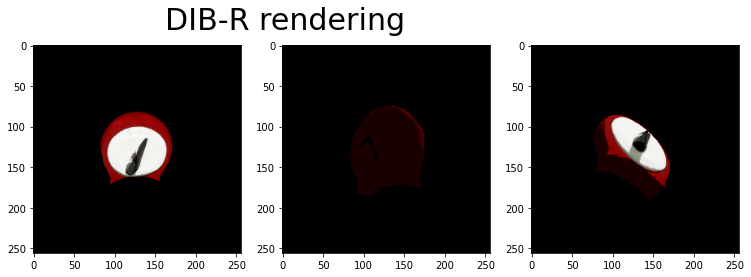

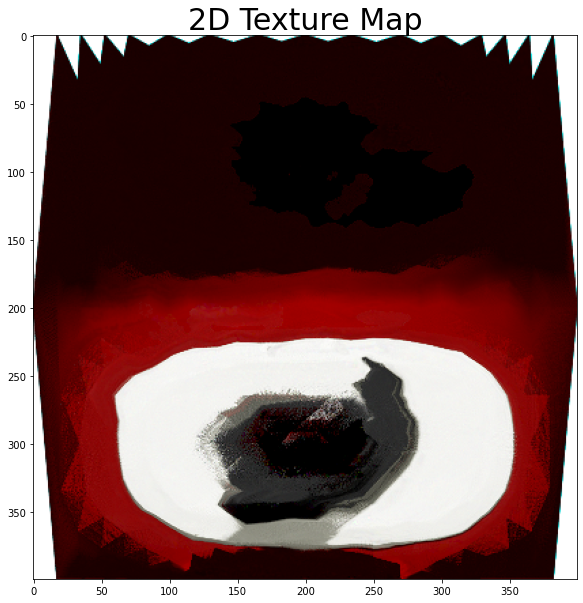

In [8]:
with torch.no_grad():
    # This is similar to a training iteration (without the loss part)
    data_batch = [train_data[idx] for idx in test_batch_ids]
    cam_transform = torch.stack([data['metadata']['cam_transform'] for data in data_batch], dim=0).cuda()
    cam_proj = torch.stack([data['metadata']['cam_proj'] for data in data_batch], dim=0).cuda()

    vertices_batch = recenter_vertices(vertices, vertice_shift)

    face_vertices_camera, face_vertices_image, face_normals = \
        kal.render.mesh.prepare_vertices(
            vertices_batch.repeat(test_batch_size, 1, 1),
            faces, cam_proj, camera_transform=cam_transform
        )

    face_attributes = [
        face_uvs.repeat(test_batch_size, 1, 1, 1),
        torch.ones((test_batch_size, nb_faces, 3, 1), device='cuda')
    ]

    image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
        256, 256, face_vertices_camera[:, :, :, -1],
        face_vertices_image, face_attributes, face_normals[:, :, -1])

    texture_coords, mask = image_features
    image = kal.render.mesh.texture_mapping(texture_coords,
                                            texture_map.repeat(test_batch_size, 1, 1, 1), 
                                            mode='bilinear')
    image = torch.clamp(image * mask, 0., 1.)
    
    ## Display the rendered images
    f, axarr = plt.subplots(1, test_batch_size, figsize=(7, 22))
    f.subplots_adjust(top=0.99, bottom=0.79, left=0., right=1.4)
    f.suptitle('DIB-R rendering', fontsize=30)
    for i in range(test_batch_size):
        axarr[i].imshow(image[i].cpu().detach())
        
## Display the texture
plt.figure(figsize=(10, 10))
plt.title('2D Texture Map', fontsize=30)
plt.imshow(torch.clamp(texture_map[0], 0., 1.).cpu().detach().permute(1, 2, 0))